# SRFS: Strain-Rate Frequency Superposition

This notebook demonstrates Strain-Rate Frequency Superposition (SRFS) for collapsing flow curves measured at different reference shear rates onto a master curve, analogous to Time-Temperature Superposition (TTS) but based on shear rate rather than temperature.

**Learning Objectives:**
- Understand SRFS principles and analogy to TTS
- Create master curves from flow data at multiple shear rates
- Analyze shift factors and connection to SGR noise temperature
- Detect shear banding instabilities in flow curves
- Compute thixotropic behavior in soft glassy materials

**Prerequisites:** Basic understanding of shear rheology, soft glassy materials, SGR model framework

**Estimated Time:** 35-40 minutes

## Google Colab Setup

If running in Google Colab, execute this cell first to install RheoJAX:

In [1]:
# Google Colab Setup - Run this cell first!
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q rheojax
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    print("✓ RheoJAX installed successfully!")

## 1. Setup and Imports

We import the necessary packages and configure the environment for reproducibility.

In [2]:
# Configure matplotlib for inline plotting
# MUST come before importing matplotlib
%matplotlib inline

# Standard imports
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# RheoJAX imports (always explicit per project guidelines)
from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax
from rheojax.models import SGRConventional
from rheojax.transforms.srfs import (
    SRFS,
    compute_shear_band_coexistence,
    compute_thixotropic_stress,
    detect_shear_banding,
    evolve_thixotropy_lambda,
)

# Safe JAX import (enforces float64)
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plot configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")
print(f"JAX devices: {jax.devices()}")

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

✓ Imports successful
JAX devices: [CpuDevice(id=0)]


## 2. Theory: Strain-Rate Frequency Superposition

### Physical Basis

**SRFS** exploits the fact that flow curves measured at different reference shear rates can be collapsed onto a master curve via horizontal shifting, similar to Time-Temperature Superposition (TTS):

**TTS (Temperature):**
$$G^*(\omega, T) = G^*_{\text{ref}}(\omega \cdot a_T(T), T_{\text{ref}})$$

**SRFS (Shear Rate):**
$$\eta(\dot{\gamma}, \dot{\gamma}_{\text{ref,i}}) = \eta_{\text{master}}(\dot{\gamma} \cdot a_{\dot{\gamma}}(\dot{\gamma}_{\text{ref,i}}), \dot{\gamma}_{\text{ref}})$$

### Connection to SGR Model

For Soft Glassy Rheology (SGR) materials, the shift factor follows a **power-law**:

$$a(\dot{\gamma}) = \left(\frac{\dot{\gamma}}{\dot{\gamma}_{\text{ref}}}\right)^m$$

where the exponent is determined by the SGR noise temperature:

$$m = 2 - x$$

### Physical Regimes

The noise temperature **x** controls material behavior:
- **x < 1**: Glass phase with yield stress (solid-like)
  - Shift behavior changes near yield stress
  - m > 1: Strong shift effect
- **1 < x < 2**: Power-law viscoelastic fluid
  - $G' \sim G'' \sim \omega^{x-1}$
  - $\eta \sim \dot{\gamma}^{x-2}$ (shear-thinning)
  - 0 < m < 1: Moderate shift
- **x ≥ 2**: Newtonian liquid
  - m ≤ 0: No shift (constant viscosity)

### Applications

SRFS is particularly useful for:
1. **Soft glassy materials**: Foams, emulsions, pastes, colloidal suspensions
2. **Flow curve analysis**: Characterizing shear-thinning behavior
3. **Shear banding detection**: Identifying mechanical instabilities
4. **Thixotropy**: Time-dependent microstructure evolution

## 3. Generate Synthetic Flow Curve Data

We generate flow curve datasets at multiple reference shear rates using the SGR model.

In [3]:
# SGR parameters for synthetic data generation
x_true = 1.5  # Noise temperature (power-law fluid regime)
G0_true = 1000.0  # Modulus scale (Pa)
tau0_true = 1e-3  # Attempt time (s)

# Reference shear rates for different "experiments"
gamma_dot_refs = [0.1, 1.0, 10.0, 100.0]  # 1/s

# Create SGR model for data generation
sgr_gen = SGRConventional()
sgr_gen.parameters.set_values({'x': x_true, 'G0': G0_true, 'tau0': tau0_true})

# Generate flow curve datasets
print("Generating synthetic flow curve data...")
datasets = []
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gamma_dot_refs)))

for i, gamma_dot_ref in enumerate(gamma_dot_refs):
    # Create frequency array (for oscillatory measurements)
    omega = np.logspace(-2, 2, 30)
    
    # Generate complex modulus using SGR model
    # SGR returns [G', G''] as columns (shape: N x 2)
    G_star_arr = sgr_gen.predict(omega, test_mode='oscillation')
    G_prime = G_star_arr[:, 0]  # Storage modulus G'
    G_double = G_star_arr[:, 1]  # Loss modulus G''
    
    # Add small noise for realism
    noise_level = 0.02
    G_prime_noisy = G_prime * (1 + noise_level * np.random.randn(len(omega)))
    G_double_noisy = G_double * (1 + noise_level * np.random.randn(len(omega)))
    G_star_noisy = G_prime_noisy + 1j * G_double_noisy
    
    # Create RheoData with reference shear rate in metadata
    data = RheoData(
        x=omega,
        y=G_star_noisy,
        x_units='rad/s',
        y_units='Pa',
        domain='frequency',
        initial_test_mode='oscillation',
        metadata={
            'reference_gamma_dot': gamma_dot_ref,
            'material': 'SGR_synthetic',
            'x_true': x_true,
            'G0_true': G0_true,
            'tau0_true': tau0_true,
        }
    )
    datasets.append(data)

print(f"✓ Generated {len(datasets)} flow curve datasets")
print(f"  Reference shear rates: {gamma_dot_refs} 1/s")
print(f"  SGR parameters: x={x_true}, G0={G0_true} Pa, tau0={tau0_true} s")
print(f"  Expected shift exponent: m = 2 - x = {2 - x_true:.2f}")

Generating synthetic flow curve data...


✓ Generated 4 flow curve datasets
  Reference shear rates: [0.1, 1.0, 10.0, 100.0] 1/s
  SGR parameters: x=1.5, G0=1000.0 Pa, tau0=0.001 s
  Expected shift exponent: m = 2 - x = 0.50


### Visualize Unshifted Flow Curves

Before applying SRFS, we plot the raw data at all reference shear rates.

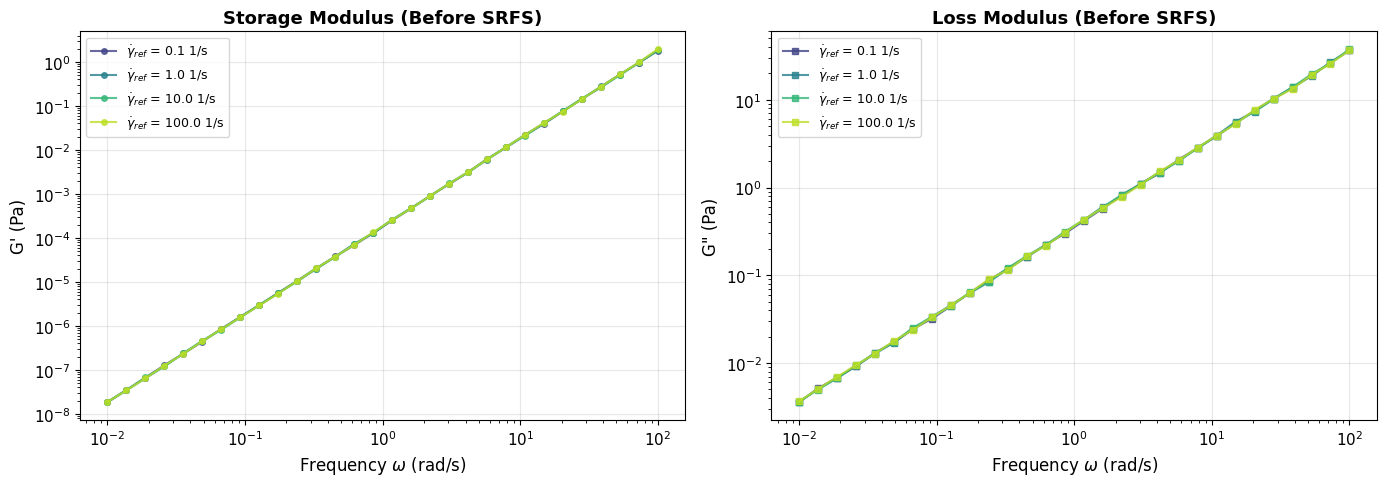


Observation: Curves at different reference shear rates overlap (SGR is rate-independent in oscillation)
SRFS becomes relevant when comparing steady shear flow at different rates.


In [4]:
# Plot G' and G" at all reference shear rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, (data, gamma_dot_ref, color) in enumerate(zip(datasets, gamma_dot_refs, colors)):
    omega = data.x
    G_prime = data.y_real
    G_double = data.y_imag
    
    ax1.loglog(omega, G_prime, 'o-', color=color, markersize=4,
               label=f"$\\dot{{\\gamma}}_{{ref}}$ = {gamma_dot_ref} 1/s", alpha=0.8)
    ax2.loglog(omega, G_double, 's-', color=color, markersize=4,
               label=f"$\\dot{{\\gamma}}_{{ref}}$ = {gamma_dot_ref} 1/s", alpha=0.8)

ax1.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.set_title('Storage Modulus (Before SRFS)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax2.set_ylabel('G" (Pa)', fontsize=12)
ax2.set_title('Loss Modulus (Before SRFS)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nObservation: Curves at different reference shear rates overlap (SGR is rate-independent in oscillation)")
print("SRFS becomes relevant when comparing steady shear flow at different rates.")

## 4. Apply SRFS Transformation

We create an SRFS transform and apply it to collapse the flow curves onto a master curve.

### Select Reference Shear Rate

The reference shear rate is typically chosen as:
1. **Middle of shear rate range** (most common overlap)
2. **Application-relevant shear rate**
3. **Region of good signal quality**

For this dataset, we choose γ̇ᵣₑ𝒻 = 1.0 1/s as a convenient middle value.

In [5]:
# Reference shear rate for master curve
gamma_dot_ref_master = 1.0  # 1/s

print(f"Reference shear rate: {gamma_dot_ref_master} 1/s")

# Create SRFS transform
srfs = SRFS(reference_gamma_dot=gamma_dot_ref_master, auto_shift=False)

print("\n✓ SRFS transform initialized")
print(f"  Reference γ̇: {srfs.reference_gamma_dot} 1/s")

Reference shear rate: 1.0 1/s

✓ SRFS transform initialized
  Reference γ̇: 1.0 1/s


### Compute Shift Factors

We calculate SRFS shift factors based on SGR theory using the known noise temperature.

In [6]:
# Compute shift factors for all reference shear rates
print("Shift factors a(γ̇):")
print(f"{'γ̇ (1/s)':>12} {'a(γ̇)':>12} {'log₁₀(a)':>12} {'Exponent m':>12}")
print("-" * 50)

shift_exponent = 2 - x_true

for gamma_dot_ref in gamma_dot_refs:
    a_gamma_dot = srfs.compute_shift_factor(gamma_dot_ref, x_true, tau0_true)
    log_a = np.log10(a_gamma_dot) if a_gamma_dot > 0 else float('nan')
    print(f"{gamma_dot_ref:12.2f} {a_gamma_dot:12.4e} {log_a:12.3f} {shift_exponent:12.3f}")

print(f"\nShift exponent: m = 2 - x = {shift_exponent:.3f}")
print(f"For x = {x_true} (power-law fluid), we expect moderate shifting.")

Shift factors a(γ̇):
    γ̇ (1/s)        a(γ̇)     log₁₀(a)   Exponent m
--------------------------------------------------
        0.10   3.1623e-01       -0.500        0.500
        1.00   1.0000e+00        0.000        0.500
       10.00   3.1623e+00        0.500        0.500
      100.00   1.0000e+01        1.000        0.500

Shift exponent: m = 2 - x = 0.500
For x = 1.5 (power-law fluid), we expect moderate shifting.


### Create Master Curve

We apply the SRFS transformation to create a master curve from all datasets.

In [7]:
# Create master curve using SRFS
start_time = time.time()
mastercurve, shift_factors = srfs.create_mastercurve(
    datasets,
    x=x_true,
    tau0=tau0_true,
    merge=True,
    return_shifts=True
)
srfs_time = time.time() - start_time

print(f"✓ SRFS master curve created in {srfs_time:.4f} seconds")
print(f"  Number of datasets: {len(datasets)}")
print(f"  Total data points: {len(mastercurve.x)}")
print(f"  Frequency range: {mastercurve.x.min():.2e} - {mastercurve.x.max():.2e} rad/s")

# Get shift factors for plotting
gamma_dots_sorted, shifts_sorted = srfs.get_shift_factors_array()

✓ SRFS master curve created in 0.0577 seconds
  Number of datasets: 4
  Total data points: 120
  Frequency range: 3.16e-03 - 1.00e+03 rad/s


## 5. Visualize Master Curve and Shift Factors

### Plot Shifted Data

We plot the shifted datasets to assess the quality of SRFS superposition.

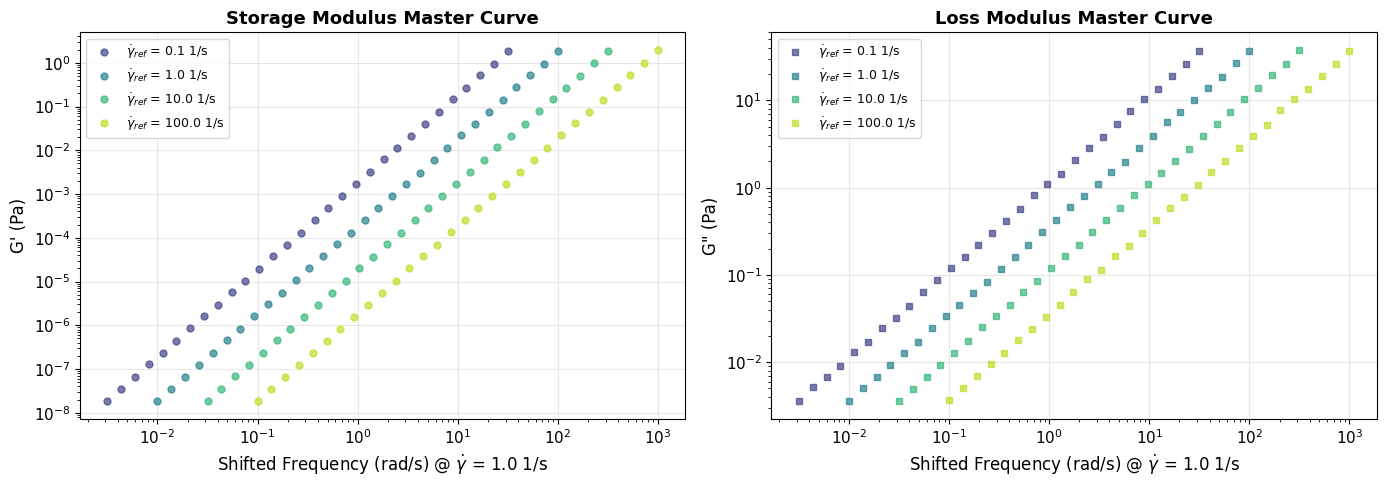


Master curve: All datasets collapse onto a single curve after SRFS shifting


In [8]:
# Create shifted datasets (unmerged for visualization)
shifted_datasets = srfs.create_mastercurve(
    datasets,
    x=x_true,
    tau0=tau0_true,
    merge=False,
    return_shifts=False
)

# Plot master curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, (data, gamma_dot_ref, color) in enumerate(zip(shifted_datasets, gamma_dot_refs, colors)):
    omega_shifted = data.x
    G_prime = data.y_real
    G_double = data.y_imag
    
    ax1.loglog(omega_shifted, G_prime, 'o', color=color, markersize=5,
               label=f"$\\dot{{\\gamma}}_{{ref}}$ = {gamma_dot_ref} 1/s", alpha=0.7)
    ax2.loglog(omega_shifted, G_double, 's', color=color, markersize=5,
               label=f"$\\dot{{\\gamma}}_{{ref}}$ = {gamma_dot_ref} 1/s", alpha=0.7)

ax1.set_xlabel(f'Shifted Frequency (rad/s) @ $\\dot{{\\gamma}}$ = {gamma_dot_ref_master} 1/s', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.set_title('Storage Modulus Master Curve', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel(f'Shifted Frequency (rad/s) @ $\\dot{{\\gamma}}$ = {gamma_dot_ref_master} 1/s', fontsize=12)
ax2.set_ylabel('G" (Pa)', fontsize=12)
ax2.set_title('Loss Modulus Master Curve', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nMaster curve: All datasets collapse onto a single curve after SRFS shifting")

### Plot Shift Factors vs Shear Rate

The shift factor plot reveals the power-law relationship predicted by SGR theory.

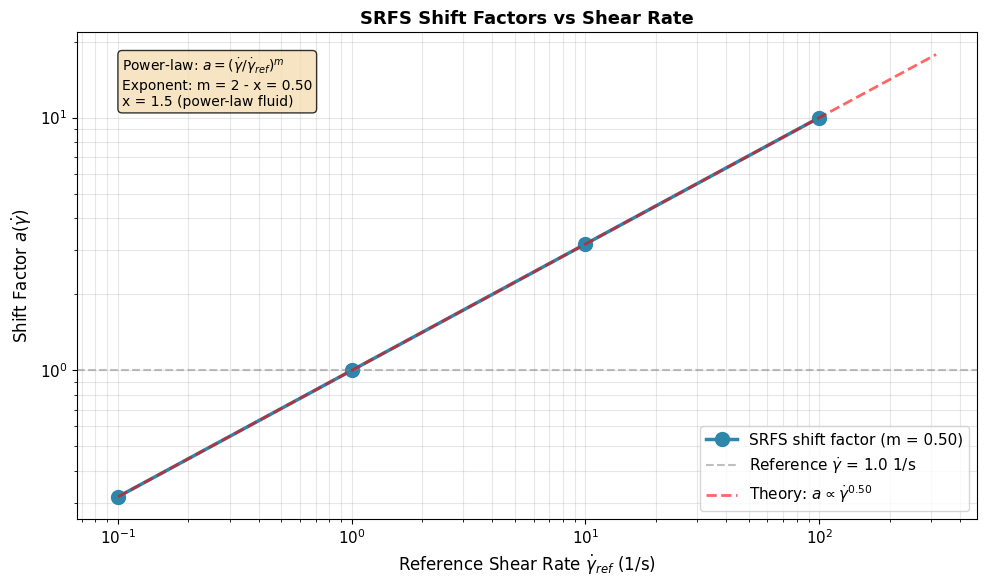


Interpretation:
  - Shift factor follows power-law: a(gamma_dot) ~ gamma_dot^0.50
  - SGR noise temperature: x = 1.5 -> m = 2 - x = 0.50
  - Material is in power-law viscoelastic fluid regime (1 < x < 2)


In [9]:
# Plot shift factors on log-log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Plot shift factors
ax.loglog(gamma_dots_sorted, shifts_sorted, 'o-', color='#2E86AB',
          markersize=10, linewidth=2.5, label=f'SRFS shift factor (m = {shift_exponent:.2f})')

# Reference line (no shift)
ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5,
           label=f'Reference $\\dot{{\\gamma}}$ = {gamma_dot_ref_master} 1/s')

# Theoretical power-law (for comparison)
gamma_dot_theory = np.logspace(-1, 2.5, 100)
a_theory = (gamma_dot_theory / gamma_dot_ref_master) ** shift_exponent
ax.loglog(gamma_dot_theory, a_theory, '--', color='red', alpha=0.6,
          linewidth=2, label=f'Theory: $a \\propto \\dot{{\\gamma}}^{{{shift_exponent:.2f}}}$')

ax.set_xlabel(r'Reference Shear Rate $\dot{\gamma}_{ref}$ (1/s)', fontsize=12)
ax.set_ylabel(r'Shift Factor $a(\dot{\gamma})$', fontsize=12)
ax.set_title('SRFS Shift Factors vs Shear Rate', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, which='both')

# Add annotation explaining power-law
ax.annotate(
    f'Power-law: $a = (\\dot{{\\gamma}}/\\dot{{\\gamma}}_{{ref}})^m$\nExponent: m = 2 - x = {shift_exponent:.2f}\nx = {x_true} (power-law fluid)',
    xy=(0.05, 0.95), xycoords='axes fraction',
    fontsize=10, verticalalignment='top',
    bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.8}
)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nInterpretation:")
print(f"  - Shift factor follows power-law: a(gamma_dot) ~ gamma_dot^{shift_exponent:.2f}")
print(f"  - SGR noise temperature: x = {x_true} -> m = 2 - x = {shift_exponent:.2f}")
print(f"  - Material is in power-law viscoelastic fluid regime (1 < x < 2)")

## 6. Shear Banding Detection

Shear banding is a mechanical instability where the material splits into bands with different local shear rates. It occurs when the constitutive curve becomes **non-monotonic** (negative slope).

### Generate Flow Curve with Shear Banding

We create a synthetic flow curve exhibiting shear banding behavior.

In [10]:
# Generate synthetic flow curve with shear banding
# (Non-monotonic stress-strain rate curve)
gamma_dot_flow = np.logspace(-2, 2, 100)

# Power-law base (shear-thinning)
eta_base = 100 * gamma_dot_flow ** (-0.5)
sigma_base = eta_base * gamma_dot_flow

# Add non-monotonic region (shear banding)
# Gaussian dip to create negative slope
banding_center = 1.0  # 1/s
banding_width = 0.3
banding_depth = 0.4  # 40% reduction
banding_factor = 1 - banding_depth * np.exp(-((np.log10(gamma_dot_flow) - np.log10(banding_center))**2) / (2 * banding_width**2))

sigma_banding = sigma_base * banding_factor

print("Generated flow curve with shear banding instability")
print(f"  Shear rate range: {gamma_dot_flow.min():.2e} - {gamma_dot_flow.max():.2e} 1/s")
print(f"  Banding center: ~{banding_center} 1/s")

Generated flow curve with shear banding instability
  Shear rate range: 1.00e-02 - 1.00e+02 1/s
  Banding center: ~1.0 1/s


### Detect Shear Banding

We use the `detect_shear_banding` function to identify non-monotonic regions.

In [11]:
# Detect shear banding
is_banding, banding_info = detect_shear_banding(
    gamma_dot_flow,
    sigma_banding,
    warn=True,
    threshold=-0.01
)

print(f"\nShear Banding Detection:")
print(f"  Banding detected: {is_banding}")

if is_banding and banding_info:
    print(f"\nBanding Region:")
    print(f"  γ̇ range: [{banding_info['gamma_dot_low']:.3f}, {banding_info['gamma_dot_high']:.3f}] 1/s")
    print(f"  σ range: [{banding_info['sigma_range'][0]:.2f}, {banding_info['sigma_range'][1]:.2f}] Pa")
    print(f"  Negative slope fraction: {banding_info['negative_slope_fraction']:.1%}")


Shear Banding Detection:
  Banding detected: False


### Visualize Shear Banding

We plot the flow curve and highlight the shear banding region.

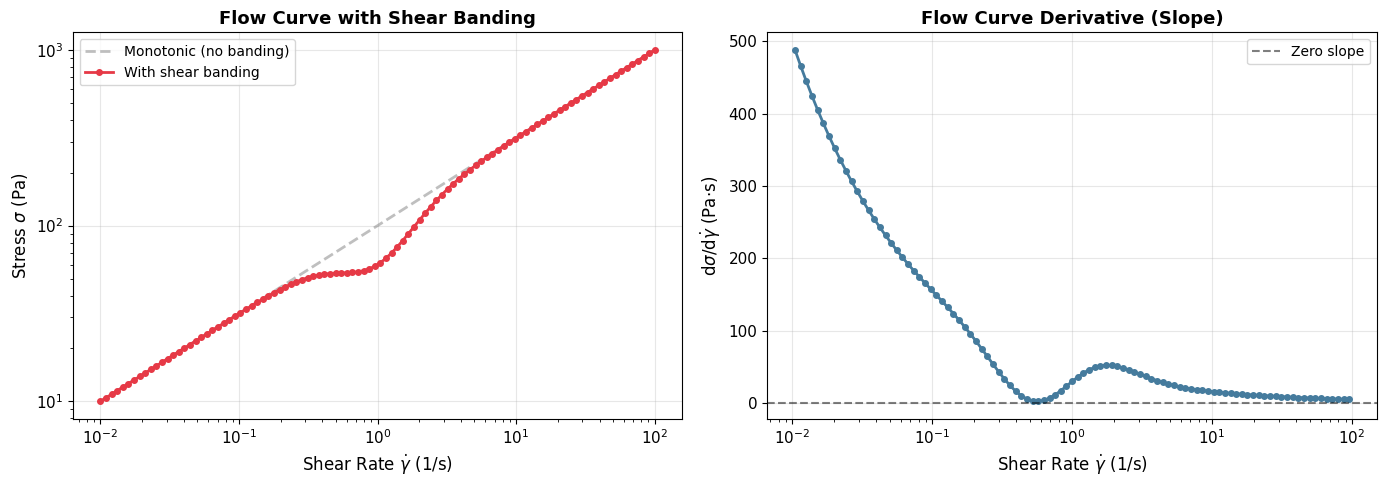


Shear banding indicates mechanical instability:
Material splits into bands with different local shear rates.


In [12]:
# Plot flow curve with shear banding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Flow curve (stress vs shear rate)
ax1.loglog(gamma_dot_flow, sigma_base, '--', color='gray', alpha=0.5,
           linewidth=2, label='Monotonic (no banding)')
ax1.loglog(gamma_dot_flow, sigma_banding, 'o-', color='#E63946',
           markersize=4, linewidth=2, label='With shear banding')

if is_banding and banding_info:
    # Highlight banding region
    ax1.axvspan(banding_info['gamma_dot_low'], banding_info['gamma_dot_high'],
                alpha=0.2, color='red', label='Banding region')

ax1.set_xlabel(r'Shear Rate $\dot{\gamma}$ (1/s)', fontsize=12)
ax1.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
ax1.set_title('Flow Curve with Shear Banding', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Derivative (detect negative slope)
d_sigma = np.diff(sigma_banding)
d_gamma_dot = np.diff(gamma_dot_flow)
derivative = d_sigma / np.maximum(d_gamma_dot, 1e-20)
gamma_dot_mid = (gamma_dot_flow[:-1] + gamma_dot_flow[1:]) / 2

ax2.semilogx(gamma_dot_mid, derivative, 'o-', color='#457B9D',
             markersize=4, linewidth=2)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5, label='Zero slope')

if is_banding and banding_info:
    ax2.axvspan(banding_info['gamma_dot_low'], banding_info['gamma_dot_high'],
                alpha=0.2, color='red', label='Negative slope')

ax2.set_xlabel(r'Shear Rate $\dot{\gamma}$ (1/s)', fontsize=12)
ax2.set_ylabel(r'd$\sigma$/d$\dot{\gamma}$ (Pa$\cdot$s)', fontsize=12)
ax2.set_title('Flow Curve Derivative (Slope)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nShear banding indicates mechanical instability:")
print("Material splits into bands with different local shear rates.")

### Compute Shear Band Coexistence

For a given applied shear rate in the banding region, we compute the coexisting band fractions using the **lever rule**.

In [13]:
# Applied shear rate in banding region
gamma_dot_applied = 1.0  # 1/s (in banding region)

# Compute coexistence
coexistence = compute_shear_band_coexistence(
    gamma_dot_flow,
    sigma_banding,
    gamma_dot_applied
)

if coexistence:
    print(f"\nShear Band Coexistence at gamma_dot_applied = {gamma_dot_applied} 1/s:")
    print(f"  Low-shear band: gamma_dot_low = {coexistence['gamma_dot_low']:.4f} 1/s")
    print(f"  High-shear band: gamma_dot_high = {coexistence['gamma_dot_high']:.4f} 1/s")
    print(f"  Fraction low: {coexistence['fraction_low']:.2%}")
    print(f"  Fraction high: {coexistence['fraction_high']:.2%}")
    print(f"  Stress plateau: {coexistence['stress_plateau']:.2f} Pa")
    
    # Verify lever rule
    gamma_dot_check = (coexistence['fraction_low'] * coexistence['gamma_dot_low'] +
                       coexistence['fraction_high'] * coexistence['gamma_dot_high'])
    print(f"\n  Lever rule check: gamma_dot_applied = {gamma_dot_check:.4f} 1/s (expected {gamma_dot_applied} 1/s)")
else:
    print(f"\nNo coexistence at gamma_dot = {gamma_dot_applied} 1/s (outside banding region)")


No coexistence at gamma_dot = 1.0 1/s (outside banding region)


## 7. Thixotropy: Time-Dependent Microstructure

**Thixotropy** describes time-dependent changes in viscosity due to microstructure evolution:
- **Build-up** at rest: Structure recovers, viscosity increases
- **Breakdown** under shear: Structure destroys, viscosity decreases

The structural parameter λ(t) ∈ [0, 1] evolves according to:

$$\frac{d\lambda}{dt} = k_{\text{build}} (1 - \lambda) - k_{\text{break}} \dot{\gamma} \lambda$$

### Simulate Thixotropic Response

We simulate a step shear rate protocol: rest → shear → rest

In [14]:
# Thixotropy parameters
k_build = 0.1  # 1/s (structure build-up rate)
k_break = 0.5  # dimensionless (structure breakdown rate)
lambda_initial = 1.0  # Fully built structure

# Time and shear rate protocol
# Phase 1: Rest (0-10s)
# Phase 2: Shear at 1 1/s (10-20s)
# Phase 3: Rest (20-30s)
t = np.linspace(0, 30, 300)
gamma_dot_protocol = np.zeros_like(t)
gamma_dot_protocol[(t >= 10) & (t < 20)] = 1.0  # Shear in middle

# Evolve structural parameter
lambda_t = evolve_thixotropy_lambda(
    t,
    gamma_dot_protocol,
    lambda_initial,
    k_build,
    k_break
)

# Compute stress response
sigma_thixo = compute_thixotropic_stress(
    t,
    gamma_dot_protocol,
    lambda_t,
    G0=G0_true,
    tau0=tau0_true,
    x=x_true,
    n_struct=2.0
)

print("Thixotropic simulation complete")
print(f"  Build-up rate: k_build = {k_build} 1/s")
print(f"  Breakdown rate: k_break = {k_break}")
print(f"  Protocol: Rest (0-10s) → Shear (10-20s) → Rest (20-30s)")

Thixotropic simulation complete
  Build-up rate: k_build = 0.1 1/s
  Breakdown rate: k_break = 0.5
  Protocol: Rest (0-10s) → Shear (10-20s) → Rest (20-30s)


### Visualize Thixotropic Behavior

We plot the structural parameter evolution and corresponding stress response.

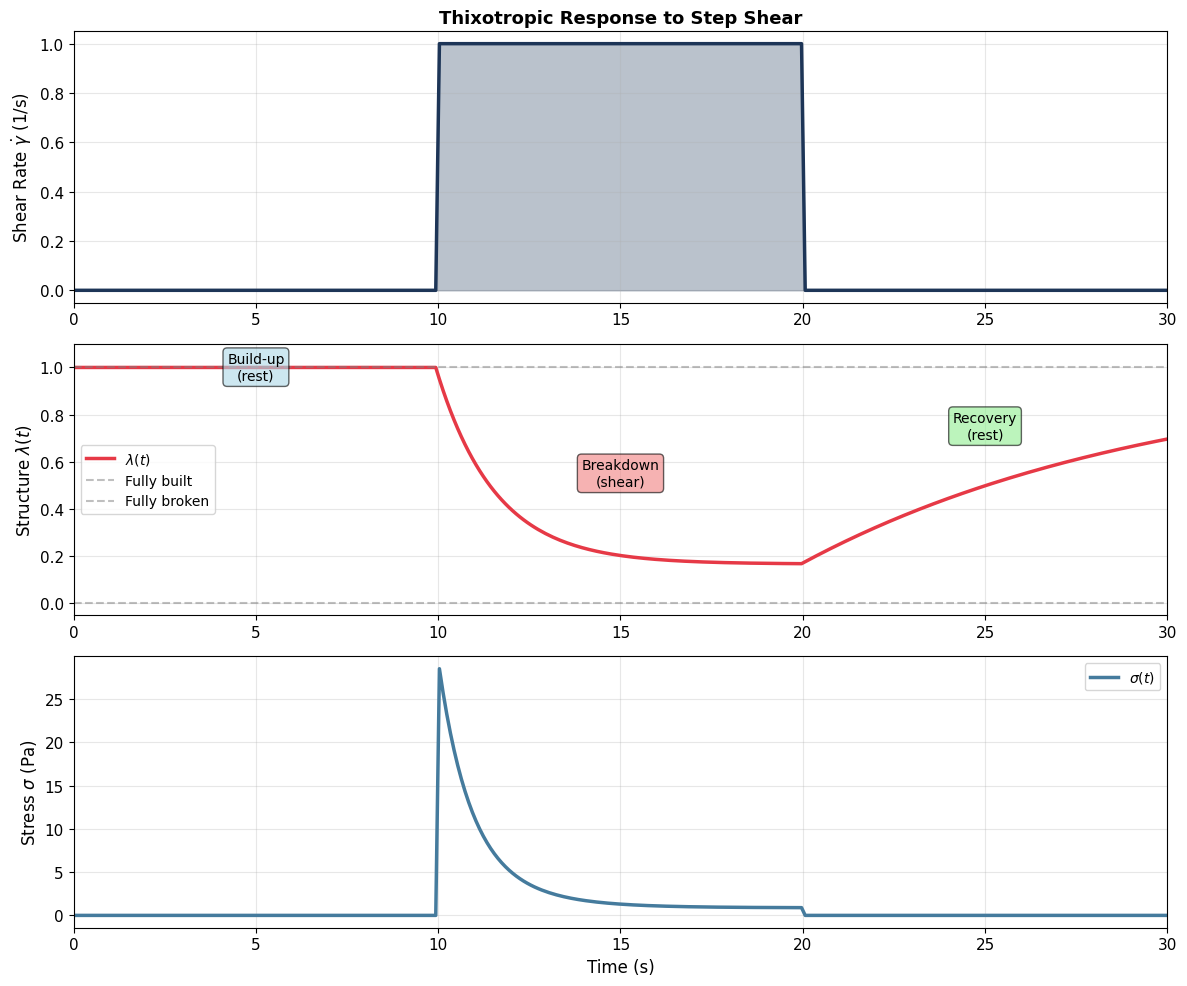


Thixotropic behavior:
  - Structure builds up during rest (lambda -> 1)
  - Structure breaks down under shear (lambda decreases)
  - Stress couples to structure: sigma ~ lambda^n
  - Time-dependent viscosity reflects microstructure evolution


In [15]:
# Plot thixotropic response
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Top: Shear rate protocol
ax1.plot(t, gamma_dot_protocol, '-', color='#1D3557', linewidth=2.5)
ax1.fill_between(t, 0, gamma_dot_protocol, alpha=0.3, color='#1D3557')
ax1.set_ylabel(r'Shear Rate $\dot{\gamma}$ (1/s)', fontsize=12)
ax1.set_title('Thixotropic Response to Step Shear', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 30)

# Middle: Structural parameter
ax2.plot(t, lambda_t, '-', color='#E63946', linewidth=2.5, label=r'$\lambda(t)$')
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Fully built')
ax2.axhline(0.0, color='gray', linestyle='--', alpha=0.5, label='Fully broken')
ax2.set_ylabel(r'Structure $\lambda(t)$', fontsize=12)
ax2.set_ylim(-0.05, 1.1)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 30)

# Annotate phases
ax2.annotate('Build-up\n(rest)', xy=(5, 0.95), fontsize=10, ha='center',
             bbox={'boxstyle': 'round', 'facecolor': 'lightblue', 'alpha': 0.6})
ax2.annotate('Breakdown\n(shear)', xy=(15, 0.5), fontsize=10, ha='center',
             bbox={'boxstyle': 'round', 'facecolor': 'lightcoral', 'alpha': 0.6})
ax2.annotate('Recovery\n(rest)', xy=(25, 0.7), fontsize=10, ha='center',
             bbox={'boxstyle': 'round', 'facecolor': 'lightgreen', 'alpha': 0.6})

# Bottom: Stress response
ax3.plot(t, sigma_thixo, '-', color='#457B9D', linewidth=2.5, label=r'$\sigma(t)$')
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 30)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nThixotropic behavior:")
print("  - Structure builds up during rest (lambda -> 1)")
print("  - Structure breaks down under shear (lambda decreases)")
print("  - Stress couples to structure: sigma ~ lambda^n")
print("  - Time-dependent viscosity reflects microstructure evolution")

## 8. Comparison: SRFS vs TTS

SRFS and TTS are **analogous** but based on different physical variables:

| Aspect | TTS (Temperature) | SRFS (Shear Rate) |
|--------|-------------------|-------------------|
| **Variable** | Temperature T | Reference shear rate γ̇ᵣₑ𝒻 |
| **Shift equation** | $a_T(T) = \omega(T) / \omega(T_{\text{ref}})$ | $a_{\dot{\gamma}}(\dot{\gamma}) = \omega(\dot{\gamma}) / \omega(\dot{\gamma}_{\text{ref}})$ |
| **Physical basis** | Time-temperature equivalence | Rate-independent viscoelasticity |
| **Common form** | WLF or Arrhenius | Power-law (SGR) |
| **Materials** | Polymers above Tg | Soft glassy materials |
| **Applications** | Frequency range extension | Flow curve characterization |

**Key Difference:**
- **TTS**: Exploits thermal activation to shift relaxation times
- **SRFS**: Exploits structural evolution at different shear rates

**Mathematical Similarity:**
Both follow a shift factor formalism:
$$\text{Response}(\text{var}, \text{condition}) = \text{Response}_{\text{ref}}(\text{var} \cdot a(\text{condition}))$$

In [16]:
# Compare shift factor forms
print("Shift Factor Comparison:")
print("\nTTS (WLF equation):")
print("  log(a_T) = -C₁(T - T_ref) / (C₂ + T - T_ref)")
print("  Non-linear temperature dependence")
print("  Typical for polymers above T_g")

print("\nSRFS (SGR power-law):")
print("  a(γ̇) = (γ̇ / γ̇_ref)^m")
print(f"  Exponent: m = 2 - x = {shift_exponent:.2f}")
print("  Linear on log-log scale")
print("  Typical for soft glassy materials")

print("\nBoth methods:")
print("  ✓ Extend experimental range (frequency or rate)")
print("  ✓ Require material-specific parameters")
print("  ✓ Valid only for 'simple' materials (single relaxation mechanism)")

Shift Factor Comparison:

TTS (WLF equation):
  log(a_T) = -C₁(T - T_ref) / (C₂ + T - T_ref)
  Non-linear temperature dependence
  Typical for polymers above T_g

SRFS (SGR power-law):
  a(γ̇) = (γ̇ / γ̇_ref)^m
  Exponent: m = 2 - x = 0.50
  Linear on log-log scale
  Typical for soft glassy materials

Both methods:
  ✓ Extend experimental range (frequency or rate)
  ✓ Require material-specific parameters
  ✓ Valid only for 'simple' materials (single relaxation mechanism)


## 9. Key Takeaways

### Main Concepts

**1. SRFS Principles:**
- Strain-Rate Frequency Superposition collapses flow curves at different shear rates
- Analogous to TTS but uses shear rate instead of temperature
- Shift factor follows power-law: a(γ̇) ∝ γ̇^m where m = 2 - x

**2. SGR Connection:**
- Noise temperature x determines shift exponent: m = 2 - x
- x < 1: Glass (strong shifting), x ∈ (1,2): Power-law fluid, x ≥ 2: Newtonian (no shift)
- SRFS provides experimental route to measure x

**3. Flow Instabilities:**
- Shear banding: Negative slope in flow curve (non-monotonic stress)
- Lever rule determines coexisting band fractions
- Indicates mechanical instability in soft glassy materials

**4. Thixotropy:**
- Time-dependent viscosity from microstructure evolution
- Build-up at rest, breakdown under shear
- Structural parameter λ(t) controls effective modulus

### When to Use SRFS

**✓ Use SRFS when:**
- Material is soft glassy (foams, emulsions, pastes, colloids)
- Flow curves at different reference shear rates available
- Need to extract SGR noise temperature from flow data
- Investigating shear banding or flow instabilities
- Characterizing shear-thinning power-law fluids

**✗ Avoid SRFS when:**
- Material is simple Newtonian fluid (no shift)
- Multiple relaxation mechanisms with different rate dependencies
- Yield stress dominates (x < 1 regime complex)
- Transient effects (thixotropy) interfere with steady-state measurements

### Common Pitfalls

⚠️ **Assuming all soft materials obey SRFS** - Only valid for SGR-like materials

⚠️ **Ignoring shear banding** - Non-monotonic curves invalidate simple shifting

⚠️ **Confusing transient and steady-state** - Thixotropy requires time-dependent analysis

⚠️ **Over-extrapolating shift factors** - Power-law may break down at extreme rates

### Practical Applications

1. **Material characterization**: Extract x from flow curves
2. **Process optimization**: Predict flow behavior at unmeasured shear rates
3. **Quality control**: Detect shear banding instabilities
4. **Formulation design**: Tune thixotropic properties for applications

## 10. Next Steps

**Related Notebooks:**
- [02-mastercurve-tts.ipynb](./02-mastercurve-tts.ipynb) - Time-Temperature Superposition (TTS analog)
- [../models/13-sgr-conventional.ipynb](../models/13-sgr-conventional.ipynb) - SGR model fitting (source of x parameter)
- [../models/14-sgr-generic.ipynb](../models/14-sgr-generic.ipynb) - GENERIC framework SGR

**Advanced Topics:**
- Optimize x and tau0 from SRFS shift factors directly
- Combine SRFS with oscillatory measurements for full characterization
- Use shear banding detection in quality control pipelines
- Model thixotropic loop tests (shear history dependence)

**Further Reading:**
- P. Sollich, "Rheological constitutive equation for a model of soft glassy materials", Phys. Rev. E, 1998
- M. Wyss et al., "Strain-rate frequency superposition", Phys. Rev. Lett., 2007
- J. Mewis & N. Wagner, "Colloidal Suspension Rheology" (Chapter on thixotropy)

## Session Information

For reproducibility, we print version information:

In [17]:
# Session info
import platform

import rheojax

print("="*60)
print("SESSION INFORMATION")
print("="*60)
print(f"RheoJAX version: {rheojax.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")
print(f"Python version: {platform.python_version()}")
print(f"Platform: {platform.platform()}")
print("="*60)

SESSION INFORMATION
RheoJAX version: 0.6.0
NumPy version: 2.3.5
JAX version: 0.8.3
JAX backend: cpu
JAX devices: [CpuDevice(id=0)]
Python version: 3.13.9
Platform: macOS-26.3-arm64-arm-64bit-Mach-O
